<a href="https://colab.research.google.com/github/AyberkMunis/Medical_Abstract_Classification/blob/main/Medical_Abstract_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Medical Abstract Classification**





## Business Problem
Most of the academic articles that are related to medical topics seem hard to read for the majority of the population. The reason why, purpose of this project is to generate a model that could divide the article's abstract into parts such as method, objective, and results to read easier. For this model, RNNs, 1-D CNNs, pre-trained, and hybrid models are used. The first models will be tried on 10% of the dataset. After that, the best model will be trained on the full data set.

# Steps of the Project

0. Importing Libraries and Needed Functions
1. Importing Data
2. RNN Models
  * LSTM
  * GRU
3. Pre Trained Embedding Models
  * USE
  * Word2Vec
4. CNN Models
5. Hybrid Models
  * Data Preperation for Hybrid Models
  * Hybrid Model 1
  * Hybrid Model with Word2Vec
  * Original Model
6. Comparing Models
7. Training the Best Model with Whole Data Set
8. Conclusion

# 0.Importing Libraries and Needed Funcitons

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
import tensorflow_hub as tfh
from sklearn.model_selection import train_test_split
from string import punctuation
import time
import random

In [ ]:
def preparedata(path):
  with open(path) as file:
    data = file.readlines()
  for i in range(0,len(data)):
    data[i]=data[i].replace("\t"," ")
    data[i]=data[i].replace("\n","")
  df={"text":[],"label":[],"id":[],"order":[]}
  t=0
  id=0
  count=0
  for i in data:
    if i=="" :
      t=0
      continue
    elif i.startswith("###"):
      t=1
      id=i[3:]
      count=1
      continue
    sen=i.split(" ")
    df["label"].append(sen[0])
    df["text"].append(" ".join(sen[1:]))
    df["id"].append(id)
    df["order"].append(count)
    count+=1
  df2=pd.DataFrame(df)
  return df2



In [ ]:
def vocab(data):
  vocab=[]
  for i in data:
    words=i.split(" ")
    for x in words:
      vocab.append(x.lower())
  return set(vocab)


In [ ]:
def removepunc(data):
  for i in punctuation:
    if i==".":
      data=data.replace(i," ")
    else:
      data=data.replace(i," ")
  data=data.replace("\n","")

  return data

In [ ]:
def masknum(data):
  data=removepunc(data)
  words=data.split(" ")
  for k,i in enumerate(words):
    if i.isnumeric():
      words[k]="@"
  return " ".join(words)

In [ ]:
def evaluate(history,start,end,model,x_test,y_test):
  pred=model.predict(x_test)
  pred=[x.argmax() for x in pred]
  acc=accuracy_score(y_test,pred)
  prec=precision_score(y_test,pred,average="micro")
  f1=f1_score(y_test,pred,average="micro")
  recc=recall_score(y_test,pred,average="micro")
  time=end-start
  cr= classification_report(y_test,pred,target_names=list(le.classes_),output_dict=True)
  return {"accuracy":acc,"precision":prec,"f1_score":f1,"recall":recc,"Training Time":time/60,"Loss":history.history["loss"],"Val Loss":history.history["val_loss"]},cr

In [ ]:
def evaluatehybrid(history,start,end,model,x_test,y_test,original=False):
  if original:
    pred=model.predict([x_test["text"],x_test["chars"]])
  else:
    pred=model.predict([x_test["text"],x_test["order"],x_test["text"]])

  pred=[x.argmax() for x in pred]
  acc=accuracy_score(y_test,pred)
  prec=precision_score(y_test,pred,average="micro")
  f1=f1_score(y_test,pred,average="micro")
  recc=recall_score(y_test,pred,average="micro")
  time=end-start
  cr= classification_report(y_test,pred,target_names=list(le.classes_),output_dict=True)
  return {"accuracy":acc,"precision":prec,"f1_score":f1,"recall":recc,"Training Time":time/60,"Loss":history.history["loss"],"Val Loss":history.history["val_loss"]},cr

In [ ]:
def classrep(model,xtest,ytest,types):
  if types==1:
    preds=model.predict(xtest["text"])
  elif types==2:
    preds=model.predict([xtest["text"],xtest["order"],xtest["text"]])
  else:
    preds=model.predict([xtest["text"],xtest["chars"]])
  preds=[x[0].argmax() for x in preds]
  return classification_report(ytest,preds,target_names=list(le.classes_),output_dict=True)

# 1.Importing Data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [ ]:
train_data=preparedata("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt")

In [ ]:
test_data=preparedata("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt")

In [ ]:
train_data["text"].dropna(inplace=True)

In [ ]:
train_data.head(20)

,text,label,id,order,chars,lenchar,length
0,To investigate the efficacy of @ weeks of dail...,OBJECTIVE,24293578,1,T o i n v e s t i g a t e t h e e f f i ...,561,49
1,A total of @ patients with primary knee OA wer...,METHODS,24293578,2,A t o t a l o f @ p a t i e n t s w ...,273,27
2,Outcome measures included pain reduction and i...,METHODS,24293578,3,O u t c o m e m e a s u r e s i n c l u d ...,221,15
3,Pain was assessed using the visual analog pain...,METHODS,24293578,4,P a i n w a s a s s e s s e d u s i n g ...,129,14
4,Secondary outcome measures included the Wester...,METHODS,24293578,5,S e c o n d a r y o u t c o m e m e a s u ...,417,35
5,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",METHODS,24293578,6,S e r u m l e v e l s o f i n t e r l e ...,293,29
6,There was a clinically relevant reduction in t...,RESULTS,24293578,7,T h e r e w a s a c l i n i c a l l y ...,321,30
7,The mean difference between treatment arms ( @...,RESULTS,24293578,8,T h e m e a n d i f f e r e n c e b e t ...,327,55
8,"Further , there was a clinically relevant redu...",RESULTS,24293578,9,"F u r t h e r , t h e r e w a s a c ...",359,36
9,These differences remained significant at @ we...,RESULTS,24293578,10,T h e s e d i f f e r e n c e s r e m a i ...,101,8


In [ ]:
len(train_data["label"].unique()),len(test_data["label"].unique()) #We have 5 classes

(5, 5)

In [ ]:
train_data["label"].unique()

array(['OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS', 'BACKGROUND'],
      dtype=object)

In [ ]:
num_classes=len(train_data["label"].unique())

In [ ]:
X_tr=train_data["text"]
y_tr=train_data["label"]


In [ ]:
X_test=test_data["text"]
y_test=test_data["label"]

In [ ]:
le=LabelEncoder()

In [ ]:
le.fit(y_tr)

LabelEncoder()

In [ ]:
le.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
y_tr=le.transform(y_tr)

In [ ]:

y_test=le.transform(y_test)

In [ ]:
le.inverse_transform(y_tr)

array(['OBJECTIVE', 'METHODS', 'METHODS', ..., 'RESULTS', 'CONCLUSIONS',
       'CONCLUSIONS'], dtype=object)

In [ ]:
y_tr=tf.keras.utils.to_categorical(y_tr,num_classes=5)

In [ ]:
y_test=tf.keras.utils.to_categorical(y_test,num_classes=5)

In [ ]:
y_tr[0]

array([0., 0., 0., 1., 0.], dtype=float32)

In [ ]:
train_data["length"]=train_data["text"].apply(lambda x: len(x.split(" ")))

In [ ]:
#Creating validation set
X_train,X_val,y_train,y_val=train_test_split(X_tr,y_tr,test_size=0.1,random_state=42)

In [ ]:
max_vocab_length=len(vocab(removepunc(train_data["text"])))
max_length=int(np.percentile(train_data["length"],95))
text_vectorizer=tf.keras.layers.TextVectorization(max_tokens=max_vocab_length,output_sequence_length=max_length)
#max_tokens number of unique words
#what is the general length of the sentences

In [ ]:
text_vectorizer.adapt(X_train)

In [ ]:
embedding=tf.keras.layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()),output_dim=128,mask_zero=True)
#input length vocabulary
#output 128
#mask_Zero

In [ ]:
embedding(text_vectorizer(X_train[0])) #Our data is ready to train

<tf.Tensor: shape=(55, 128), dtype=float32, numpy=
array([[ 0.04079313,  0.01598537, -0.03337141, ..., -0.0181043 ,
        -0.04551936,  0.02842579],
       [ 0.00045115, -0.01541656,  0.03260818, ...,  0.00975074,
         0.01825389,  0.00920411],
       [ 0.02253034,  0.0449309 ,  0.00989623, ...,  0.01962345,
        -0.04791022,  0.01113548],
       ...,
       [ 0.02004797,  0.01611196, -0.04588726, ..., -0.00921141,
        -0.02617501,  0.04682103],
       [ 0.02004797,  0.01611196, -0.04588726, ..., -0.00921141,
        -0.02617501,  0.04682103],
       [ 0.02004797,  0.01611196, -0.04588726, ..., -0.00921141,
        -0.02617501,  0.04682103]], dtype=float32)>

In [ ]:
train=tf.data.Dataset.from_tensor_slices((X_train,y_train))
val=tf.data.Dataset.from_tensor_slices((X_val,y_val))

In [ ]:
test=tf.data.Dataset.from_tensor_slices((X_test,y_test))
test=test.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train=train.batch(32).prefetch(tf.data.AUTOTUNE)
val=val.batch(32).prefetch(tf.data.AUTOTUNE)

# 2. RNN models

##LSTM

In [ ]:
lr=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10 ** (epoch/20))
es=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)

In [ ]:
inputs=tf.keras.layers.Input(shape=[],dtype="string",name="input layer")
x=text_vectorizer(inputs)
x=embedding(x)
x=tf.keras.layers.LSTM(32)(x)
x=tf.keras.layers.Dropout(0.5)(x)
output=tf.keras.layers.Dense(5,activation="softmax",name="output")(x)
modelLSTM=tf.keras.Model(inputs,output,name="modelLSTM")

In [ ]:
modelLSTM.summary()

Model: "modelLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input layer (InputLayer)    [(None,)]                 0         
                                                                 
 text_vectorization_2 (Text  (None, 55)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 55, 128)           7984640   
                                                                 
 lstm_8 (LSTM)               (None, 32)                20608     
                                                                 
 dropout_17 (Dropout)        (None, 32)                0         
                                                                 
 output (Dense)              (None, 5)                 165       
                                                         

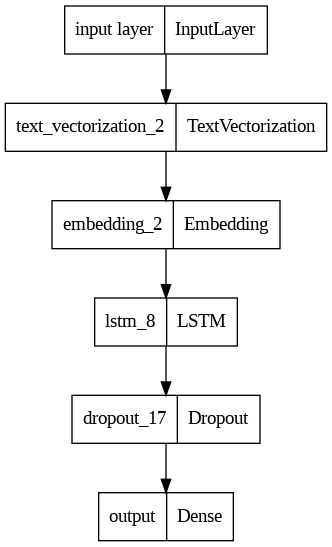

In [ ]:
tf.keras.utils.plot_model(modelLSTM)

In [ ]:
modelLSTM.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [ ]:
startLSTM=time.time()
historyLSTM=modelLSTM.fit(train,epochs=10,validation_data=val,callbacks=[es])
endLSTM=time.time()

Epoch 1/10
5064/5064 [==============================] - 85s 16ms/step - loss: 0.6401 - accuracy: 0.7683 - val_loss: 0.5061 - val_accuracy: 0.8182
Epoch 2/10
5064/5064 [==============================] - 53s 10ms/step - loss: 0.4522 - accuracy: 0.8447 - val_loss: 0.5084 - val_accuracy: 0.8178
Epoch 3/10
5064/5064 [==============================] - 53s 10ms/step - loss: 0.3530 - accuracy: 0.8813 - val_loss: 0.5632 - val_accuracy: 0.8117
Epoch 4/10
5064/5064 [==============================] - 54s 11ms/step - loss: 0.2790 - accuracy: 0.9078 - val_loss: 0.6517 - val_accuracy: 0.8025


In [ ]:
eLSTM=evaluate(historyLSTM,startLSTM,endLSTM,modelLSTM,X_test,y_test)

942/942 [==============================] - 3s 3ms/step


## GRU

In [ ]:
inputs=tf.keras.layers.Input(shape=[],dtype="string",name="input layer")
x=text_vectorizer(inputs)
x=embedding(x)
x=tf.keras.layers.GRU(128)(x)
x=tf.keras.layers.Dense(128,activation="relu")(x)
output=tf.keras.layers.Dense(5,activation="softmax",name="output")(x)
modelGRU=tf.keras.Model(inputs,output,name="modelGRU")

In [ ]:
modelGRU.summary()

Model: "modelGRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input layer (InputLayer)    [(None,)]                 0         
                                                                 
 text_vectorization_2 (Text  (None, 55)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 55, 128)           7984640   
                                                                 
 gru (GRU)                   (None, 128)               99072     
                                                                 
 dense_17 (Dense)            (None, 128)               16512     
                                                                 
 output (Dense)              (None, 5)                 645       
                                                          

In [ ]:
modelGRU.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [ ]:
startGru=time.time()
historyGRU=modelGRU.fit(train,epochs=10,validation_data=val,callbacks=[es])
endGRU=time.time()

Epoch 1/10
5064/5064 [==============================] - 85s 16ms/step - loss: 0.2808 - accuracy: 0.9033 - val_loss: 0.6910 - val_accuracy: 0.7904
Epoch 2/10
5064/5064 [==============================] - 54s 11ms/step - loss: 0.1744 - accuracy: 0.9414 - val_loss: 0.8911 - val_accuracy: 0.7837
Epoch 3/10
5064/5064 [==============================] - 53s 10ms/step - loss: 0.1259 - accuracy: 0.9574 - val_loss: 1.1136 - val_accuracy: 0.7767
Epoch 4/10
5064/5064 [==============================] - 53s 11ms/step - loss: 0.0947 - accuracy: 0.9678 - val_loss: 1.2144 - val_accuracy: 0.7747


In [ ]:
eGRU=evaluate(historyGRU,startGru,endGRU,modelGRU,X_test,y_test)

942/942 [==============================] - 3s 3ms/step


In [ ]:
eGRU

{'accuracy': 0.7690061390409823,
 'precision': 0.7690061390409823,
 'f1_score': 0.7690061390409821,
 'recall': 0.7690061390409823,
 'Training Time': 4.50966510772705,
 'Loss': [0.2584991157054901,
  0.15341080725193024,
  0.11111153662204742,
  0.08539798110723495,
  0.06666866689920425],
 'Val Loss': [0.7727308869361877,
  0.9882160425186157,
  1.1312443017959595,
  1.3564479351043701,
  1.4182393550872803]}

BiDirectional

In [ ]:
inputs=tf.keras.layers.Input(shape=[],dtype="string",name="input layer")
x=text_vectorizer(inputs)
x=embedding(x)
x=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
output=tf.keras.layers.Dense(5,activation="softmax",name="output")(x)
modelBi=tf.keras.Model(inputs,output,name="modelBi")

In [ ]:
modelBi.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [ ]:
startBi=time.time()
historyBi=modelBi.fit(train,epochs=10,validation_data=val,callbacks=[es])
endBi=time.time()

Epoch 1/10
5064/5064 [==============================] - 109s 20ms/step - loss: 0.1808 - accuracy: 0.9392 - val_loss: 0.9204 - val_accuracy: 0.7729
Epoch 2/10
5064/5064 [==============================] - 70s 14ms/step - loss: 0.0947 - accuracy: 0.9682 - val_loss: 1.1240 - val_accuracy: 0.7662
Epoch 3/10
5064/5064 [==============================] - 70s 14ms/step - loss: 0.0682 - accuracy: 0.9775 - val_loss: 1.2534 - val_accuracy: 0.7702
Epoch 4/10
5064/5064 [==============================] - 70s 14ms/step - loss: 0.0534 - accuracy: 0.9825 - val_loss: 1.4381 - val_accuracy: 0.7670


In [ ]:
eBi=evaluate(historyBi,startBi,endBi,modelBi,X_test,y_test)

942/942 [==============================] - 4s 4ms/step


In [ ]:
eBi

{'accuracy': 0.763265306122449,
 'precision': 0.763265306122449,
 'f1_score': 0.7632653061224491,
 'recall': 0.763265306122449,
 'Training Time': 5.321403114000956,
 'Loss': [0.18078245222568512,
  0.09466154873371124,
  0.06817422807216644,
  0.053442928940057755],
 'Val Loss': [0.9204418063163757,
  1.1240004301071167,
  1.2533787488937378,
  1.4380998611450195]}

# 2. Pretrained Embedding Models

## USE

In [ ]:
sentence_encode_layer=tfh.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",trainable=False)

In [ ]:
inputs=tf.keras.layers.Input(shape=[],dtype="string",name="input layer")
x=sentence_encode_layer(inputs)
x=tf.keras.layers.Dense(256,activation="relu")(x)
output=tf.keras.layers.Dense(5,activation="softmax",name="output")(x)
modeluse=tf.keras.Model(inputs,output,name="modeluse")

In [ ]:
modeluse.summary()

Model: "modeluse"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input layer (InputLayer)    [(None,)]                 0         
                                                                 
 keras_layer_4 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_18 (Dense)            (None, 256)               131328    
                                                                 
 output (Dense)              (None, 5)                 1285      
                                                                 
Total params: 256930437 (980.11 MB)
Trainable params: 132613 (518.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
modeluse.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [ ]:
startuse=time.time()
historyuse=modeluse.fit(train,epochs=50,validation_data=val,callbacks=[es])
enduse=time.time()

Epoch 1/50
5064/5064 [==============================] - 54s 10ms/step - loss: 0.7106 - accuracy: 0.7280 - val_loss: 0.6387 - val_accuracy: 0.7594
Epoch 2/50
5064/5064 [==============================] - 49s 10ms/step - loss: 0.6157 - accuracy: 0.7668 - val_loss: 0.6086 - val_accuracy: 0.7707
Epoch 3/50
5064/5064 [==============================] - 49s 10ms/step - loss: 0.5771 - accuracy: 0.7823 - val_loss: 0.5988 - val_accuracy: 0.7749
Epoch 4/50
5064/5064 [==============================] - 49s 10ms/step - loss: 0.5486 - accuracy: 0.7935 - val_loss: 0.5965 - val_accuracy: 0.7770
Epoch 5/50
5064/5064 [==============================] - 50s 10ms/step - loss: 0.5255 - accuracy: 0.8033 - val_loss: 0.5989 - val_accuracy: 0.7758
Epoch 6/50
5064/5064 [==============================] - 50s 10ms/step - loss: 0.5053 - accuracy: 0.8114 - val_loss: 0.6053 - val_accuracy: 0.7748
Epoch 7/50
5064/5064 [==============================] - 50s 10ms/step - loss: 0.4875 - accuracy: 0.8182 - val_loss: 0.6129 -

In [ ]:
eUSE=evaluate(historyuse,startuse,enduse,modeluse,X_test,y_test)

942/942 [==============================] - 7s 8ms/step


## Word 2 Vector

In [ ]:
word2vec=tf.keras.layers.Embedding(max_vocab_length,
                                      128,
                                      input_length=[],
                                      name="w2v_embedding")

In [ ]:
inputs=tf.keras.layers.Input(shape=[],dtype="string",name="input layer")
x=text_vectorizer(inputs)
x=word2vec(x)
x=tf.keras.layers.Dense(256,activation="relu")(x)
x=tf.keras.layers.GlobalAveragePooling1D()(x)
output=tf.keras.layers.Dense(5,activation="softmax",name="output")(x)
modelword2vec=tf.keras.Model(inputs,output,name="modelw2v")

In [ ]:
modelword2vec.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [ ]:
modelword2vec.summary()

Model: "modelw2v"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input layer (InputLayer)    [(None,)]                 0         
                                                                 
 text_vectorization_2 (Text  (None, 55)                0         
 Vectorization)                                                  
                                                                 
 w2v_embedding (Embedding)   (None, 55, 128)           8925824   
                                                                 
 dense_19 (Dense)            (None, 55, 256)           33024     
                                                                 
 global_average_pooling1d_3  (None, 256)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 output (Dense)              (None, 5)                 128

In [ ]:
startw2v=time.time()
historyword2vec=modelword2vec.fit(train,epochs=50,validation_data=val,callbacks=[es])
endw2v=time.time()

Epoch 1/50
5064/5064 [==============================] - 56s 11ms/step - loss: 0.6376 - accuracy: 0.7649 - val_loss: 0.5627 - val_accuracy: 0.7994
Epoch 2/50
5064/5064 [==============================] - 28s 6ms/step - loss: 0.4785 - accuracy: 0.8314 - val_loss: 0.5801 - val_accuracy: 0.7953
Epoch 3/50
5064/5064 [==============================] - 28s 6ms/step - loss: 0.4069 - accuracy: 0.8602 - val_loss: 0.6308 - val_accuracy: 0.7855
Epoch 4/50
5064/5064 [==============================] - 28s 6ms/step - loss: 0.3565 - accuracy: 0.8798 - val_loss: 0.6953 - val_accuracy: 0.7747


In [ ]:
ew2v=evaluate(historyword2vec,startw2v,endw2v,modelword2vec,X_test,y_test)

942/942 [==============================] - 2s 2ms/step


# CNN Model

In [ ]:
inputs=tf.keras.layers.Input(shape=[],dtype="string",name="input layer")
x=text_vectorizer(inputs)
x=embedding(x)
x=tf.keras.layers.Conv1D(32,5)(x)
x=tf.keras.layers.MaxPool1D()(x)
x=tf.keras.layers.Dropout(0.4)(x)
x=tf.keras.layers.GlobalAveragePooling1D()(x)
output=tf.keras.layers.Dense(5,activation="softmax",name="output")(x)
modelCNN=tf.keras.Model(inputs,output,name="modelCNN")

In [ ]:
modelCNN.summary()

Model: "modelCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input layer (InputLayer)    [(None,)]                 0         
                                                                 
 text_vectorization_2 (Text  (None, 55)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 55, 128)           7984640   
                                                                 
 conv1d (Conv1D)             (None, 51, 32)            20512     
                                                                 
 max_pooling1d (MaxPooling1  (None, 25, 32)            0         
 D)                                                              
                                                                 
 dropout_18 (Dropout)        (None, 25, 32)            0  

In [ ]:
modelCNN.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.SGD(),metrics=["accuracy"])

In [ ]:
startcnn=time.time()
historycnn=modelCNN.fit(train,epochs=50,validation_data=val,callbacks=[es])
endcnn=time.time()

Epoch 1/50
5064/5064 [==============================] - 45s 8ms/step - loss: 0.8882 - accuracy: 0.6908 - val_loss: 0.7327 - val_accuracy: 0.7245
Epoch 2/50
5064/5064 [==============================] - 24s 5ms/step - loss: 0.5871 - accuracy: 0.7927 - val_loss: 0.6830 - val_accuracy: 0.7435
Epoch 3/50
5064/5064 [==============================] - 23s 5ms/step - loss: 0.5250 - accuracy: 0.8159 - val_loss: 0.6687 - val_accuracy: 0.7529
Epoch 4/50
5064/5064 [==============================] - 23s 5ms/step - loss: 0.4901 - accuracy: 0.8283 - val_loss: 0.6649 - val_accuracy: 0.7589
Epoch 5/50
5064/5064 [==============================] - 23s 5ms/step - loss: 0.4693 - accuracy: 0.8369 - val_loss: 0.6650 - val_accuracy: 0.7633
Epoch 6/50
5064/5064 [==============================] - 23s 5ms/step - loss: 0.4534 - accuracy: 0.8424 - val_loss: 0.6653 - val_accuracy: 0.7678
Epoch 7/50
5064/5064 [==============================] - 23s 5ms/step - loss: 0.4419 - accuracy: 0.8463 - val_loss: 0.6678 - val_ac

In [ ]:
ecnn=evaluate(historycnn,startcnn,endcnn,modelCNN,X_test,y_test)

942/942 [==============================] - 2s 2ms/step


# Hybrid Models

Now we will create hybrid models, with different structures. Our first hybrid model will take token embeddings, order of sentences, and sentence embeddings as inputs. Our second model will use word2vec for token embeddings, the remaining parts are the same. Finally, we will design a very similar model to the original paper's model which takes a token and character embedding as input. (Paper:https://arxiv.org/pdf/1612.05251.pdf)

##Data Preperation for Hybrid Models

In [ ]:
def space(data):
  return " ".join(list(data))

In [ ]:
from string import digits,punctuation,ascii_letters,ascii_lowercase

In [ ]:
train_data["chars"]=train_data["text"].apply(space)


In [ ]:
test_data["chars"]=test_data["text"].apply(space)

In [ ]:
test_data

,text,label,id,order,chars
0,This study analyzed liver function abnormaliti...,BACKGROUND,24845963,1,T h i s s t u d y a n a l y z e d l i v ...
1,A post hoc analysis was conducted with the use...,RESULTS,24845963,2,A p o s t h o c a n a l y s i s w a s ...
2,Liver function tests ( LFTs ) were measured at...,RESULTS,24845963,3,L i v e r f u n c t i o n t e s t s ( ...
3,Survival analyses were used to assess the asso...,RESULTS,24845963,4,S u r v i v a l a n a l y s e s w e r e ...
4,The percentage of patients with abnormal LFTs ...,RESULTS,24845963,5,T h e p e r c e n t a g e o f p a t i e ...
...,...,...,...,...,...
30130,There was a statistically significant between-...,RESULTS,24261927,14,T h e r e w a s a s t a t i s t i c a l ...
30131,There were no statistically significant betwee...,RESULTS,24261927,15,T h e r e w e r e n o s t a t i s t i c ...
30132,There was no significant association between s...,RESULTS,24261927,16,T h e r e w a s n o s i g n i f i c a n ...
30133,No adverse effects were reported .,RESULTS,24261927,17,N o a d v e r s e e f f e c t s w e r e ...


In [ ]:
train_data

,text,label,id,order,chars
0,To investigate the efficacy of @ weeks of dail...,OBJECTIVE,24293578,1,T o i n v e s t i g a t e t h e e f f i ...
1,A total of @ patients with primary knee OA wer...,METHODS,24293578,2,A t o t a l o f @ p a t i e n t s w ...
2,Outcome measures included pain reduction and i...,METHODS,24293578,3,O u t c o m e m e a s u r e s i n c l u d ...
3,Pain was assessed using the visual analog pain...,METHODS,24293578,4,P a i n w a s a s s e s s e d u s i n g ...
4,Secondary outcome measures included the Wester...,METHODS,24293578,5,S e c o n d a r y o u t c o m e m e a s u ...
...,...,...,...,...,...
180035,For the absolute change in percent atheroma vo...,RESULTS,26227186,8,F o r t h e a b s o l u t e c h a n g e ...
180036,"For PAV , a significantly greater percentage o...",RESULTS,26227186,9,"F o r P A V , a s i g n i f i c a n t ..."
180037,Both strategies had acceptable side effect pro...,RESULTS,26227186,10,B o t h s t r a t e g i e s h a d a c c ...
180038,"Compared with standard statin monotherapy , th...",CONCLUSIONS,26227186,11,C o m p a r e d w i t h s t a n d a r d ...


In [ ]:
X_test_char=test_data[["text","chars","order"]]

In [ ]:
train_data["lenchar"]=train_data["chars"].apply(lambda x:len(x))

In [ ]:
outputlen=np.quantile(train_data["lenchar"],0.95)

<Axes: >

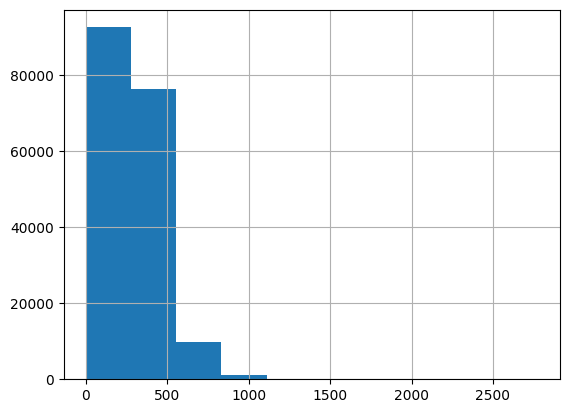

In [ ]:
train_data["lenchar"].hist()

In [ ]:
train_data["length"]=train_data["text"].apply(lambda x: len(x.split(" ")))

In [ ]:
X_tr_char=train_data[["text","chars","order"]]
y_tr=train_data["label"]

In [ ]:
X_c_train,X_c_val,y_c_train,y_c_test=train_test_split(X_tr_char,y_tr,test_size=0.1,random_state=42)

In [ ]:
voc=digits+punctuation+ascii_letters

In [ ]:
characther_vectorizer=tf.keras.layers.TextVectorization(max_tokens=len(voc),output_sequence_length=int(outputlen))

In [ ]:
characther_vectorizer.adapt(X_c_train["chars"])

In [ ]:
char_embedding=tf.keras.layers.Embedding(input_dim=len(characther_vectorizer.get_vocabulary()),output_dim=128,mask_zero=True)

In [ ]:
max_vocab_length=len(vocab(removepunc(train_data["text"])))
max_length=int(np.percentile(train_data["length"],95))
text_vectorizer=tf.keras.layers.TextVectorization(max_tokens=max_vocab_length,output_sequence_length=max_length)


In [ ]:
text_vectorizer.adapt(X_c_train["text"])

In [ ]:
embedding=tf.keras.layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()),output_dim=128,mask_zero=True)

## Hybrid Model 1

In [ ]:
token_inputs=tf.keras.layers.Input(shape=[],dtype="string")
token_=text_vectorizer(token_inputs)
token_=embedding(token_)
token_=tf.keras.layers.LSTM(32)(token_)
token_output=tf.keras.layers.Dense(16,activation="relu")(token_)
token_=tf.keras.layers.Dropout(0.5)(token_)

token_model=tf.keras.Model(token_inputs,token_output)

In [ ]:
sentence_encode_layer=tfh.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",trainable=False)
sentence_inputs=tf.keras.layers.Input(shape=[],dtype="string")
sentence_=sentence_encode_layer(sentence_inputs)
sentence_=tf.keras.layers.Dense(32,activation="relu")(sentence_)
sentence_output=tf.keras.layers.Dropout(0.5)(sentence_)
sentence_model=tf.keras.Model(sentence_inputs,sentence_output)

In [ ]:
order_inputs=tf.keras.layers.Input(shape=(1,),dtype=tf.float32)
order_=tf.keras.layers.Dense(32,activation="relu")(order_inputs)
order_output=tf.keras.layers.Dense(16,activation="relu")(order_)
order_model=tf.keras.Model(order_inputs,order_output)

In [ ]:
combinedInput = tf.keras.layers.Concatenate(name="concentate")([token_model.output,order_model.output,sentence_model.output])
x=tf.keras.layers.Dense(8,activation="relu",name="fcltotal")(combinedInput)
x=tf.keras.layers.Dropout(0.2)(x)
output=tf.keras.layers.Dense(5,activation="softmax",name="output")(x)
hybridmodel=tf.keras.Model(inputs=[token_model.input,order_model.input,sentence_model.input],outputs=output,name="HybridModel")


In [ ]:
hybridmodel.summary()

Model: "HybridModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 55)                   0         ['input_1[0][0]']             
 Vectorization)                                                                                   
                                                                                                  
 input_2 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 55, 128)              7984640   ['text_vectorization

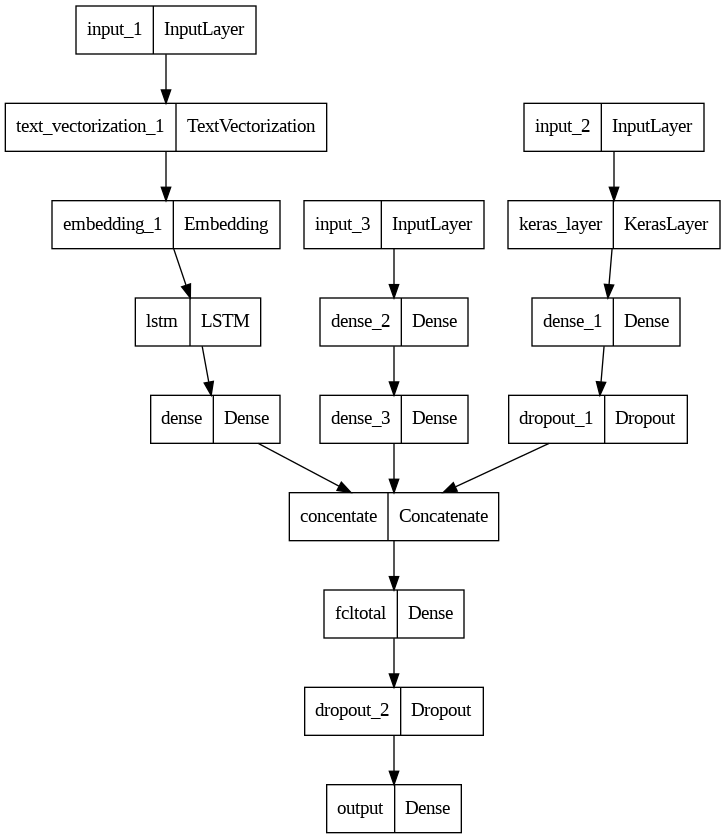

In [ ]:
tf.keras.utils.plot_model(hybridmodel)

In [ ]:
hybridmodel.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [ ]:
X_c_train

,text,chars,order
144310,"Additionally , a process evaluation will shed ...","A d d i t i o n a l l y , a p r o c e s ...",10
126174,To compare the long-term efficacy of a corneal...,T o c o m p a r e t h e l o n g - t e r ...,1
172937,"Carotenoids were measured in serum , HDL@ and ...",C a r o t e n o i d s w e r e m e a s u r ...,7
124441,"However , there is a need for further studies ...","H o w e v e r , t h e r e i s a n e ...",11
66520,The effect of reposition was evaluated based u...,T h e e f f e c t o f r e p o s i t i o ...,6
...,...,...,...
7014,Intravenous ketamine produces rapid reductions...,I n t r a v e n o u s k e t a m i n e p r ...,9
33162,We performed a randomised crossover trial of C...,W e p e r f o r m e d a r a n d o m i s ...,3
121212,This strongly supports the incorporation of pa...,T h i s s t r o n g l y s u p p o r t s ...,15
150570,Salsalate had no effects on adipose tissue inc...,S a l s a l a t e h a d n o e f f e c t ...,9


In [ ]:
es=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)

In [ ]:
starthybrid=time.time()
histroyhybird=hybridmodel.fit(x=[X_c_train["text"],X_c_train["order"],X_c_train["text"]],y=y_c_train,epochs=3,validation_data=([X_c_val["text"],X_c_val["order"],X_c_val["text"]],y_c_test),
                callbacks=[es])
endhybrid=time.time()

Epoch 1/3
5064/5064 [==============================] - 130s 24ms/step - loss: 0.6247 - accuracy: 0.7470 - val_loss: 0.4013 - val_accuracy: 0.8579
Epoch 2/3
5064/5064 [==============================] - 86s 17ms/step - loss: 0.4496 - accuracy: 0.8149 - val_loss: 0.3778 - val_accuracy: 0.8613
Epoch 3/3
5064/5064 [==============================] - 86s 17ms/step - loss: 0.3728 - accuracy: 0.8559 - val_loss: 0.3963 - val_accuracy: 0.8619


In [ ]:
X_test_char2=tf.data.Dataset.from_tensor_slices((X_test_char["text"],X_test_char["order"],X_test_char["text"]))

In [ ]:
ehybrid=evaluatehybrid(histroyhybird,starthybrid,endhybrid,hybridmodel,X_test_char,y_test)

942/942 [==============================] - 8s 8ms/step


In [ ]:
ehybrid

{'accuracy': 0.7570930811348929,
 'precision': 0.7570930811348929,
 'f1_score': 0.7570930811348929,
 'recall': 0.7570930811348929,
 'Training Time': 5.029965551694234,
 'Loss': [0.624688982963562, 0.44955769181251526, 0.37275439500808716],
 'Val Loss': [0.4013367295265198, 0.3778270483016968, 0.39628171920776367]}

## Hybrid Model with Word2Vec

In [ ]:
word2vec=tf.keras.layers.Embedding(max_vocab_length,
                                      128,
                                      input_length=[],
                                      name="w2v_embedding")
word2vecinputs=tf.keras.layers.Input(shape=[],dtype="string")
w2v_=text_vectorizer(word2vecinputs)
w2v_=word2vec(w2v_)
w2v_=tf.keras.layers.Dense(32,activation="relu")(w2v_)
w2v_=tf.keras.layers.GlobalAveragePooling1D()(w2v_)
w2v_=tf.keras.layers.Dense(8,activation="relu")(w2v_)
modelword2vec=tf.keras.Model(word2vecinputs,w2v_,name="modelw2v")

In [ ]:
combinedInput2 = tf.keras.layers.Concatenate(name="concentate")([modelword2vec.output,order_model.output,sentence_model.output])
x=tf.keras.layers.Dense(8,activation="relu",name="fcltotal")(combinedInput2)
x=tf.keras.layers.Dropout(0.2)(x)
output=tf.keras.layers.Dense(5,activation="softmax",name="output")(x)
hybridmodel2=tf.keras.Model(inputs=[modelword2vec.input,order_model.input,sentence_model.input],outputs=output,name="HybridModelWord2vec")


In [ ]:
hybridmodel2.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [ ]:
starthybrid2=time.time()
histroyhybird2=hybridmodel2.fit(x=[X_c_train["text"],X_c_train["order"],X_c_train["text"]],y=y_c_train,epochs=3,validation_data=([X_c_val["text"],X_c_val["order"],X_c_val["text"]],y_c_test),
                callbacks=[es])
endhybrid2=time.time()

Epoch 1/3
5064/5064 [==============================] - 107s 20ms/step - loss: 0.6360 - accuracy: 0.7453 - val_loss: 0.4074 - val_accuracy: 0.8512
Epoch 2/3
5064/5064 [==============================] - 73s 14ms/step - loss: 0.4636 - accuracy: 0.8247 - val_loss: 0.3903 - val_accuracy: 0.8536
Epoch 3/3
5064/5064 [==============================] - 72s 14ms/step - loss: 0.4130 - accuracy: 0.8425 - val_loss: 0.4011 - val_accuracy: 0.8533


In [ ]:
ehybrid2=evaluatehybrid(histroyhybird2,starthybrid2,endhybrid2,hybridmodel2,X_test_char,y_test)

942/942 [==============================] - 8s 8ms/step


##Original Model

In [ ]:
sentence_inputs2=tf.keras.layers.Input(shape=[],dtype="string")
sentence_2=sentence_encode_layer(sentence_inputs2)
sentence_2=tf.keras.layers.Dense(32,activation="relu")(sentence_2)

sentence_model2=tf.keras.Model(sentence_inputs2,sentence_2)
char_inputs2=tf.keras.layers.Input(shape=(1,),dtype="string")
char_2=characther_vectorizer(char_inputs2)
char_2=char_embedding(char_2)
char_2=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(char_2)

char_model2=tf.keras.Model(char_inputs2,char_2)
combinedInput3 = tf.keras.layers.Concatenate(name="concentate")([sentence_model2.output,char_model2.output])
x=tf.keras.layers.Dropout(0.5)(combinedInput3)
x=tf.keras.layers.Dense(32,activation="relu")(x)
x=tf.keras.layers.Dropout(0.5)(combinedInput3)
output=tf.keras.layers.Dense(5,activation="softmax",name="output")(x)
modelorginal=tf.keras.Model(inputs=[sentence_model2.input,char_model2.input],outputs=output,name="HybridModel3")

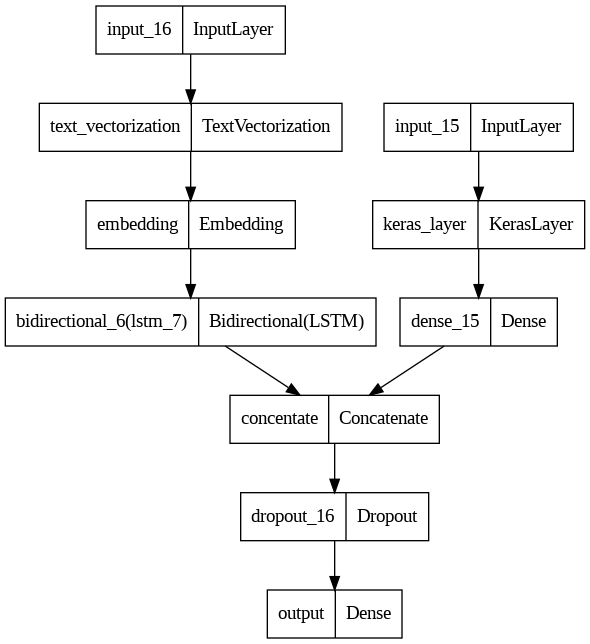

In [ ]:
tf.keras.utils.plot_model(modelorginal)

In [ ]:
modelorginal.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [ ]:
startorginal=time.time()
histroyorginal=modelorginal.fit(x=[X_c_train["text"],X_c_train["chars"]],y=y_c_train,epochs=3,validation_data=([X_c_val["text"],X_c_val["chars"]],y_c_test),
                callbacks=[es])
endorginal=time.time()

Epoch 1/3
5064/5064 [==============================] - 220s 42ms/step - loss: 0.7941 - accuracy: 0.6957 - val_loss: 0.6547 - val_accuracy: 0.7552
Epoch 2/3
5064/5064 [==============================] - 207s 41ms/step - loss: 0.6963 - accuracy: 0.7365 - val_loss: 0.6379 - val_accuracy: 0.7601
Epoch 3/3
5064/5064 [==============================] - 208s 41ms/step - loss: 0.6741 - accuracy: 0.7463 - val_loss: 0.5995 - val_accuracy: 0.7752


In [ ]:
eorginal=evaluatehybrid(histroyorginal,startorginal,endorginal,modelorginal,X_test_char,y_test,original=True)

942/942 [==============================] - 13s 13ms/step


In [ ]:
eorginal

{'accuracy': 0.7715281234444997,
 'precision': 0.7715281234444997,
 'f1_score': 0.7715281234444997,
 'recall': 0.7715281234444997,
 'Training Time': 10.594043882687886,
 'Loss': [0.7940797805786133, 0.6963464617729187, 0.6740726828575134],
 'Val Loss': [0.6546759009361267, 0.6379380822181702, 0.5994555354118347]}

# Comparing Models

In [ ]:
X_test

0        This study analyzed liver function abnormaliti...
1        A post hoc analysis was conducted with the use...
2        Liver function tests ( LFTs ) were measured at...
3        Survival analyses were used to assess the asso...
4        The percentage of patients with abnormal LFTs ...
                               ...                        
30130    There was a statistically significant between-...
30131    There were no statistically significant betwee...
30132    There was no significant association between s...
30133                   No adverse effects were reported .
30134    Performing a @-week do-as-tolerated program of...
Name: text, Length: 30135, dtype: object

In [ ]:
X_test_char

,text,chars,order
0,This study analyzed liver function abnormaliti...,T h i s s t u d y a n a l y z e d l i v ...,1
1,A post hoc analysis was conducted with the use...,A p o s t h o c a n a l y s i s w a s ...,2
2,Liver function tests ( LFTs ) were measured at...,L i v e r f u n c t i o n t e s t s ( ...,3
3,Survival analyses were used to assess the asso...,S u r v i v a l a n a l y s e s w e r e ...,4
4,The percentage of patients with abnormal LFTs ...,T h e p e r c e n t a g e o f p a t i e ...,5
...,...,...,...
30130,There was a statistically significant between-...,T h e r e w a s a s t a t i s t i c a l ...,14
30131,There were no statistically significant betwee...,T h e r e w e r e n o s t a t i s t i c ...,15
30132,There was no significant association between s...,T h e r e w a s n o s i g n i f i c a n ...,16
30133,No adverse effects were reported .,N o a d v e r s e e f f e c t s w e r e ...,17


In [ ]:
hybridmodel2.evaluate([X_test_char["text"],X_test_char["order"],X_test_char["text"]])

942/942 [==============================] - 3s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
evaluations=[eLSTM[0],eGRU[0],eUSE[0],ew2v[0],ecnn[0],ehybrid[0],ehybrid2[0],eorginal[0]]
df={"accuracy":[],"f1_score":[],"Training Time":[],"val_loss":[],"loss":[],"Models":["LSTM","GRU","USE","W2V","CNN","Hybrid","Hybrid with W2V","Orginal Model"]}

In [ ]:
for i in evaluations:
  df["accuracy"].append(i["accuracy"])
  df["f1_score"].append(i["f1_score"])
  df["Training Time"].append(i["Training Time"])
  df["val_loss"].append(i["Val Loss"])
  df["loss"].append(i["Loss"])

In [ ]:
df=pd.DataFrame(df,index=df["Models"]).drop("Models",axis=1)

<Figure size 640x480 with 0 Axes>

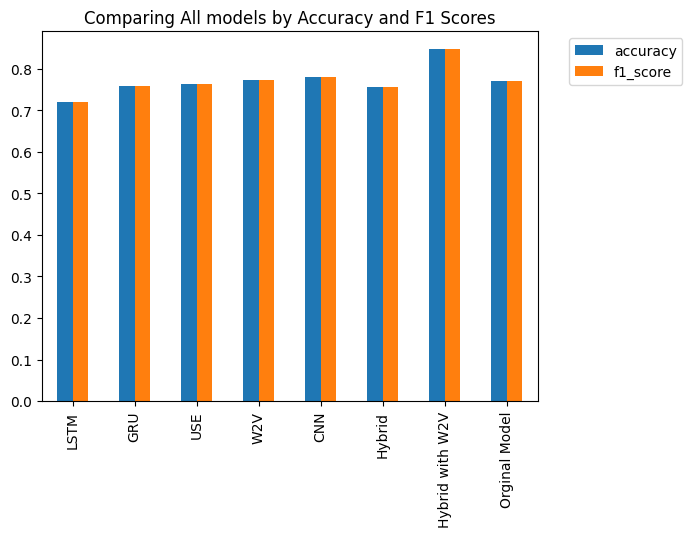

In [ ]:

plt.figure()
df[["accuracy","f1_score"]].plot(kind="bar",title="Comparing All models by Accuracy and F1 Scores").legend(bbox_to_anchor=(1.05, 1), loc='upper left')


<Axes: title={'center': 'Comparing All models by Training Time'}>

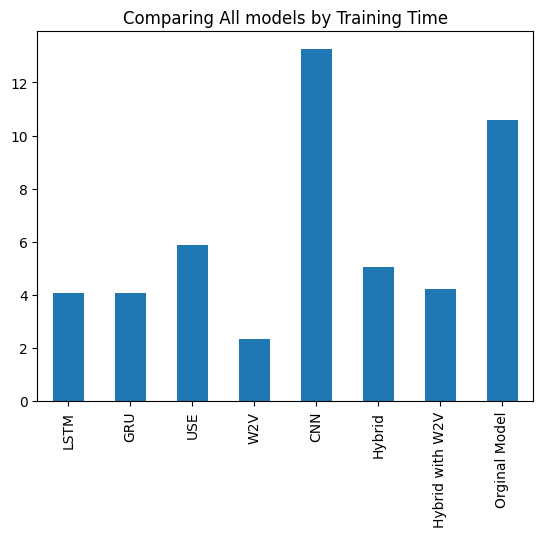

In [ ]:
plt.figure()
df["Training Time"].plot(kind="bar",title="Comparing All models by Training Time")

In [ ]:
cfehybrid2=pd.DataFrame(ehybrid2[1]).T
cfehybrid2.drop(["macro avg","weighted avg","accuracy"],inplace=True,axis=0)
cfehybrid2.sort_values("f1-score") #The model had problems about classifying objective class

,precision,recall,f1-score,support
OBJECTIVE,0.759615,0.474068,0.583795,2333.0
BACKGROUND,0.698276,0.827672,0.757488,3621.0
CONCLUSIONS,0.830255,0.884927,0.856719,4571.0
RESULTS,0.919020,0.834243,0.874582,9713.0
METHODS,0.869321,0.939679,0.903132,9897.0


In [ ]:
cfcnn=pd.DataFrame(ecnn[1]).T
cfcnn.drop(["macro avg","weighted avg","accuracy"],inplace=True,axis=0)
cfcnn.sort_values("f1-score") #The model had also problems about classifying objective

,precision,recall,f1-score,support
OBJECTIVE,0.700988,0.364766,0.479842,2333.0
BACKGROUND,0.578081,0.678818,0.624413,3621.0
CONCLUSIONS,0.688729,0.689783,0.689256,4571.0
RESULTS,0.859314,0.838258,0.848655,9713.0
METHODS,0.838263,0.899161,0.867645,9897.0


In [ ]:
cforg=pd.DataFrame(eorginal[1]).T
cforg.drop(["macro avg","weighted avg","accuracy"],inplace=True,axis=0)
cforg.sort_values("f1-score") #This model has better performance on classifying objective class

,precision,recall,f1-score,support
BACKGROUND,0.598062,0.562552,0.579764,3621.0
OBJECTIVE,0.713793,0.532362,0.609870,2333.0
CONCLUSIONS,0.675596,0.651061,0.663102,4571.0
RESULTS,0.827159,0.839082,0.833078,9713.0
METHODS,0.824248,0.893705,0.857572,9897.0


In [ ]:
#We will investigate what will model predicts for an objective for real.
obj=test_data[test_data["label"]=="OBJECTIVE"]
obj.reset_index(inplace=True)


In [ ]:
idx=random.randint(0,len(obj))
samppred=hybridmodel2.predict([obj["text"],obj["order"],obj["text"]])


73/73 [==============================] - 1s 9ms/step


In [ ]:
samppred=[x.argmax() for x in samppred]

In [ ]:
samppred=le.inverse_transform(samppred)

In [ ]:
comp=pd.DataFrame({"Predictions":samppred,"Real":obj["label"],"id":range(0,len(obj))})
comp.head()

,Predictions,Real,id
0,BACKGROUND,OBJECTIVE,0
1,BACKGROUND,OBJECTIVE,1
2,BACKGROUND,OBJECTIVE,2
3,OBJECTIVE,OBJECTIVE,3
4,OBJECTIVE,OBJECTIVE,4


In [ ]:
comp.groupby("Predictions").agg({"Predictions":"count"})

,Predictions
Predictions,
BACKGROUND,1073
CONCLUSIONS,2
METHODS,146
OBJECTIVE,1106
RESULTS,6


In [ ]:
#Model has bias to say background instead of objective

In [ ]:
#Lets compare objective and background sentences
idx=random.randint(0,len(obj))
print(test_data.loc[(test_data["id"]==obj.iloc[idx]["id"]) & (test_data["label"]=="OBJECTIVE")].iloc[0]["text"])
print(test_data.loc[(test_data["id"]==obj.iloc[idx]["id"]) & (test_data["label"]=="BACKGROUND")].iloc[0]["text"])

In a pilot study , we evaluated whether the peroxisome proliferator-activated receptor-gamma ( PPAR - ) agonist pioglitazone or combined endurance and resistance exercise training improves basal myocardial insulin sensitivity and diastolic function in HIV + adults with peripheral metabolic complications .
Individuals with HIV infection and peripheral metabolic complications have impaired basal myocardial insulin sensitivity that is related to left ventricular ( LV ) diastolic dysfunction .




Most probably, the reason for bias is having objective and background similar context because the background is a previous step of defining the objective, therefore both sentences could include similar words such as disease name, etc.

# Training the best model with whole data set

In [ ]:
!unzip /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip

Archive:  /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip
  inflating: train.txt               


In [ ]:
trainall=preparedata("/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt")
testall=preparedata("/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt")

In [ ]:
X_a_tr=trainall[["text","order"]]
y_a_tr=trainall["label"]

In [ ]:
y_a_tr=le.transform(y_a_tr)

In [ ]:
y_a_tr=tf.keras.utils.to_categorical(y_a_tr,num_classes=5)

In [ ]:
X_a_train,X_a_val,y_a_train,y_a_val=train_test_split(X_a_tr,y_a_tr,test_size=0.1,random_state=42)

In [ ]:
traina=tf.data.Dataset.from_tensor_slices(((X_a_train["text"],X_a_train["order"],X_a_train["text"]),y_a_train))

In [ ]:
vala=tf.data.Dataset.from_tensor_slices(((X_a_val["text"],X_a_val["order"],X_a_val["text"]),y_a_val))

In [ ]:
traina=traina.batch(32).prefetch(tf.data.AUTOTUNE)
vala=vala.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
X_a_test=testall[["text","order"]]

In [ ]:
y_a_test=testall[["label"]]

In [ ]:
y_a_test=le.transform(y_a_test)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [ ]:
combinedInput3 = tf.keras.layers.Concatenate()([modelword2vec.output,order_model.output,sentence_model.output])
x=tf.keras.layers.Dense(8,activation="relu")(combinedInput3)
x=tf.keras.layers.Dropout(0.2)(x)
output_test=tf.keras.layers.Dense(5,activation="softmax")(x)
hybridmodeltest=tf.keras.Model(inputs=[modelword2vec.input,order_model.input,sentence_model.input],outputs=output_test,name="HybridModelTest")

In [ ]:
hybridmodeltest.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [ ]:
hybridmodeltest.summary()

Model: "HybridModelTest"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input layer (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 text_vectorization_2 (Text  (None, 55)                   0         ['input layer[0][0]']         
 Vectorization)                                                                                   
                                                                                                  
 w2v_embedding (Embedding)   (None, 55, 128)              8925824   ['text_vectorization_2[3][0]']
                                                                                                  
 input_2 (InputLayer)        [(None,)]                    0         []              

In [ ]:
hybridmodeltest.fit(traina,epochs=50,validation_data=vala,callbacks=[es])

Epoch 1/50
62209/62209 [==============================] - 856s 14ms/step - loss: 0.4755 - accuracy: 0.8231 - val_loss: 0.3549 - val_accuracy: 0.8695
Epoch 2/50
62209/62209 [==============================] - 827s 13ms/step - loss: 0.4259 - accuracy: 0.8464 - val_loss: 0.3536 - val_accuracy: 0.8698
Epoch 3/50
62209/62209 [==============================] - 814s 13ms/step - loss: 0.4128 - accuracy: 0.8520 - val_loss: 0.3608 - val_accuracy: 0.8686
Epoch 4/50
62209/62209 [==============================] - 808s 13ms/step - loss: 0.3979 - accuracy: 0.8594 - val_loss: 0.3703 - val_accuracy: 0.8667
Epoch 5/50
62209/62209 [==============================] - 800s 13ms/step - loss: 0.3840 - accuracy: 0.8669 - val_loss: 0.3810 - val_accuracy: 0.8613


In [ ]:
testpred=hybridmodeltest.predict([X_a_test["text"],X_a_test["order"],X_a_test["text"]])

922/922 [==============================] - 8s 8ms/step


In [ ]:
testpred=[x.argmax() for x in testpred]

In [ ]:
ehybridtest={"accuracy":accuracy_score(y_a_test,testpred),"f1_score":f1_score(y_a_test,testpred,average="micro"),"recall":recall_score(y_a_test,testpred,average="micro")}

In [ ]:
ehybridtest

{'accuracy': 0.8629505306343879,
 'f1_score': 0.8629505306343879,
 'recall': 0.8629505306343879}

In [ ]:
dfhybridtest=pd.DataFrame(ehybridtest,index=["Hybrid Model  trained by 200k data"])

<Axes: title={'center': 'Metrics of Our Test Model'}>

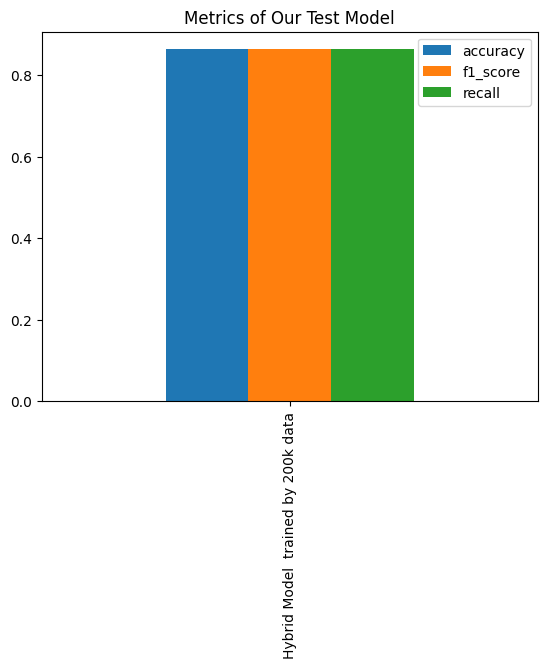

In [ ]:
dfhybridtest.plot(kind="bar",title="Metrics of Our Test Model")

In [ ]:
crtest=classification_report(y_a_test,testpred,output_dict=True,target_names=list(le.classes_))

In [ ]:
crtestdf=pd.DataFrame(crtest).T
crtestdf # Our f1 and precision score of model are increased yeey. Also our general accuracy is increased also

,precision,recall,f1-score,support
BACKGROUND,0.691118,0.788960,0.736805,2663.000000
CONCLUSIONS,0.845177,0.886805,0.865491,4426.000000
METHODS,0.887097,0.936314,0.911041,9751.000000
OBJECTIVE,0.779707,0.604544,0.681043,2377.000000
RESULTS,0.915650,0.862009,0.888020,10276.000000
accuracy,0.862951,0.862951,0.862951,0.862951
macro avg,0.823750,0.815726,0.816480,29493.000000
weighted avg,0.864404,0.862951,0.861915,29493.000000


In [ ]:
ehybrid2[0]["accuracy"]

0.8478845196615231

In [ ]:
print(f"Old Accuracy: {ehybrid2[0]['accuracy']}\nNew Accuracy: {ehybridtest['accuracy']}\nDifference: {ehybridtest['accuracy']-ehybrid2[0]['accuracy']}")

Old Accuracy: 0.8478845196615231
New Accuracy: 0.8629505306343879
Difference: 0.015066010972864752


In [ ]:
ehybrid2[0]

{'accuracy': 0.8478845196615231,
 'precision': 0.8478845196615231,
 'f1_score': 0.8478845196615231,
 'recall': 0.8478845196615231,
 'Training Time': 4.200460112094879,
 'Loss': [0.6360347270965576, 0.4636002480983734, 0.41300979256629944],
 'Val Loss': [0.407386839389801, 0.39030927419662476, 0.4010586440563202]}

# Conclusion

We tried to solve this problem by using 8 different deep-learning models. The best 3 models are the 1-D CNN model, a remake of the original model, and our hybrid model which uses Word2Vec for token embedding. If we take into account the accuracy-training time tradeoff, our hybrid model wins the race. We could reach approximately 85% accuracy in 4 minutes with 20k data. After that, we trained the same model with a larger dataset (containing 200k data). This process increased the accuracy and other metrics by 2%.